Load HCP data and connectivity analysis.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import plotting, datasets
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
import seaborn as sns

# Plotting functions

In [2]:
def plot_eigenvalues(evals):
  """
  Plots eigenvalues.

  Args:
      (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """
  plt.figure(figsize=(4, 4))
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  plt.xticks(np.arange(1, len(evals) + 1))
  plt.ylim([0, 2.5])
  plt.show()


def plot_data(X):
  """
  Plots bivariate data. Includes a plot of each random variable, and a scatter
  scatter plot of their joint activity. The title indicates the sample
  correlation calculated from the data.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(X[:, 0], color='k')
  plt.ylabel('Neuron 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(X[:, 1], color='k')
  plt.xlabel('Sample Number (sorted)')
  plt.ylabel('Neuron 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(X[:, 0], X[:, 1], '.', markerfacecolor=[.5, .5, .5],
           markeredgewidth=0)
  ax3.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(X[:, 0], X[:, 1])[0, 1]))
  plt.show()


def plot_data_new_basis(Y):
  """
  Plots bivariate data after transformation to new bases. Similar to plot_data
  but with colors corresponding to projections onto basis 1 (red) and
  basis 2 (blue).
  The title indicates the sample correlation calculated from the data.

  Note that samples are re-sorted in ascending order for the first random
  variable.

  Args:
    Y (numpy array of floats) : Data matrix in new basis each column
                                corresponds to a different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(Y[:, 0], 'r')
  plt.ylabel('Projection \n basis vector 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(Y[:, 1], 'b')
  plt.xlabel('Sample number')
  plt.ylabel('Projection \n basis vector 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(Y[:, 0], Y[:, 1], '.', color=[.5, .5, .5])
  ax3.axis('equal')
  plt.xlabel('Projection basis vector 1')
  plt.ylabel('Projection basis vector 2')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(Y[:, 0], Y[:, 1])[0, 1]))
  plt.show()


def plot_basis_vectors(X, W):
  """
  Plots bivariate data as well as new basis vectors.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    W (numpy array of floats) : Square matrix representing new orthonormal
                                basis each column represents a basis vector

  Returns:
    Nothing.
  """

  plt.figure(figsize=[4, 4])
  plt.plot(X[:, 0], X[:, 1], '.', color=[.5, .5, .5], label='Data')
  plt.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.plot([0, W[0, 0]], [0, W[1, 0]], color='r', linewidth=3,
           label='Basis vector 1')
  plt.plot([0, W[0, 1]], [0, W[1, 1]], color='b', linewidth=3,
           label='Basis vector 2')
  plt.legend()
  plt.show()

# Data load

#%pip install google.colab
#from google.colab import drive
"""
import os
import requests
import tarfile

# Montar Google Drive
#drive.mount('/content/drive')

# Definir directorios y archivos
#drive_dir = "/content/drive/My Drive/HCP_data"
dir = r"C:\Users\cwako\OneDrive\NMA"
os.makedirs(dir, exist_ok=True)
fnames = ["hcp_rest.tgz",
          "hcp_task.tgz",
          "hcp_covariates.tgz",
          "atlas.npz"]
urls = ["https://osf.io/bqp7m/download",
        "https://osf.io/s4h8j/download",
        "https://osf.io/x5p4g/download",
        "https://osf.io/j5kuc/download"]
# Función para descargar archivos
def download_file(url, fname):
    try:
        r = requests.get(url)
        r.raise_for_status()  # Check for HTTP errors
    except requests.ConnectionError:
        print("!!! Failed to download data: Connection Error !!!")
    except requests.HTTPError as err:
        print(f"!!! Failed to download data: HTTP Error {err} !!!")
    else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
            fid.write(r.content)
        print(f"Download {fname} completed!")

# Descargar los archivos si no existen en Google Drive
for fname, url in zip(fnames, urls):
    drive_path = os.path.join(dir, fname)
    if not os.path.isfile(drive_path):
        download_file(url, drive_path)
    else:
        print(f"{fname} already exists in Google Drive.")

# Si necesitas extraer los archivos
def extract_file(filepath, extract_to):
    if tarfile.is_tarfile(filepath):
        with tarfile.open(filepath) as tar:
            tar.extractall(path=extract_to)
        print(f"Extracted {os.path.basename(filepath)} to {extract_to}")
    else:
        print(f"{os.path.basename(filepath)} is not a valid tar file.")

for fname in fnames:
    drive_path = os.path.join(dir, fname)
    extract_file(drive_path, dir)
"""

In [3]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = r"C:\Users\cwako\OneDrive\NMA"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# MATRIX LOADING

In [4]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
             i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
             ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}'")
  return run_ids


def load_timeseries(subject, name, dir,
                    runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    dir (str) : data directory
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, name, condition, dir):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition
    dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

Extract and concatenate timeseries

In [5]:
timeseries = load_timeseries(subject=0,
                             name="rest",
                             dir=os.path.join(HCP_DIR, "hcp_rest"),
                             runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


In [6]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, name="rest",
                              dir=os.path.join(HCP_DIR, "hcp_rest"))
  timeseries_rest.append(ts_concat)

print(type(timeseries_rest))

<class 'list'>


In [7]:
print(type(timeseries_rest[0]))
print(timeseries_rest[0].shape)

<class 'numpy.ndarray'>
(360, 4800)


Construct functional connectivity matrix (FC)

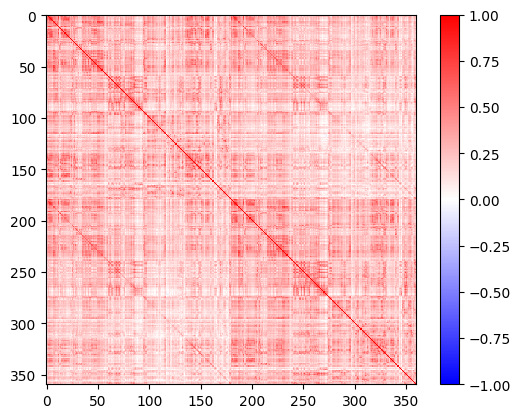

In [8]:
f_connectivity_matrix = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  f_connectivity_matrix[sub] = np.corrcoef(ts)

group_fc = f_connectivity_matrix.mean(axis=0)

plt.figure()
plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [9]:
lower_triangle = np.tril(f_connectivity_matrix, k=-1)

# Average difficulty vector

     Subject  AVG_DIFFICULTY_LEVEL  Label
0          0              8.892857      0
1          1             10.089286      0
2          2             10.053571      0
3          3              8.767857      0
4          4              9.357143      0
..       ...                   ...    ...
334      334             12.446429      1
335      335              8.750000      0
336      336              9.464286      0
337      337             11.178571      1
338      338              9.375000      0

[339 rows x 3 columns]


C:\Users\cwako\AppData\Local\Temp\ipykernel_1608\2132344249.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_dif_df['Label'] = (avg_dif_df['AVG_DIFFICULTY_LEVEL'] > threshold).astype(int)


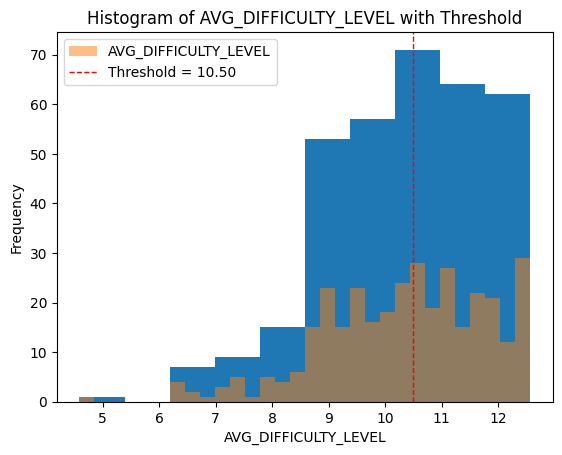

[0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1
 0 0 1 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1
 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1
 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0
 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0
 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0
 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0
 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1
 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0
 0 1 0 0 1 0]


In [10]:
from sklearn.preprocessing import normalize

language_csv = r"C:\Users\cwako\OneDrive\NMA\hcp\behavior\language.csv"
language_df = pd.read_csv(language_csv)
filtered_df = language_df[language_df['ConditionName'] == 'STORY']
run_mean = filtered_df.groupby('Subject')[['ACC', 'AVG_DIFFICULTY_LEVEL', 'MEDIAN_RT']].mean().reset_index()

avg_dif_df = run_mean[['Subject', 'AVG_DIFFICULTY_LEVEL']]

avg_dif_df.head()

#plt.hist(run_mean['ACC'])
plt.hist(run_mean['AVG_DIFFICULTY_LEVEL'])

# Define the threshold
threshold = 10.5

# Function to assign the labels, if value in the column is above the threshold Ture, as tyoe converts boolean into binary numbers (0, 1)
avg_dif_df['Label'] = (avg_dif_df['AVG_DIFFICULTY_LEVEL'] > threshold).astype(int)
print(avg_dif_df)

# Histogram of average difficulty
plt.hist(avg_dif_df['AVG_DIFFICULTY_LEVEL'], bins=30, alpha=0.5, label='AVG_DIFFICULTY_LEVEL')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label=f'Threshold = {threshold:.2f}')
plt.xlabel('AVG_DIFFICULTY_LEVEL')
plt.ylabel('Frequency')
plt.title('Histogram of AVG_DIFFICULTY_LEVEL with Threshold')
plt.legend()
plt.show()

# Vector de etiquetas
labels_vector = avg_dif_df['Label'].values
print(labels_vector)

In [11]:
print(max(avg_dif_df['AVG_DIFFICULTY_LEVEL']))
print(min(avg_dif_df['AVG_DIFFICULTY_LEVEL']))

12.57142857145
4.589285714285


# Accuracy vectors

     Subject    ACC  Label
0          0  0.875      1
1          1  1.000      1
2          2  1.000      1
3          3  0.750      0
4          4  0.875      1
..       ...    ...    ...
334      334  1.000      1
335      335  0.875      1
336      336  0.875      1
337      337  1.000      1
338      338  1.000      1

[339 rows x 3 columns]


C:\Users\cwako\AppData\Local\Temp\ipykernel_1608\3974314006.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_m['Label'] = (accuracy_m['ACC'] > threshold).astype(int)


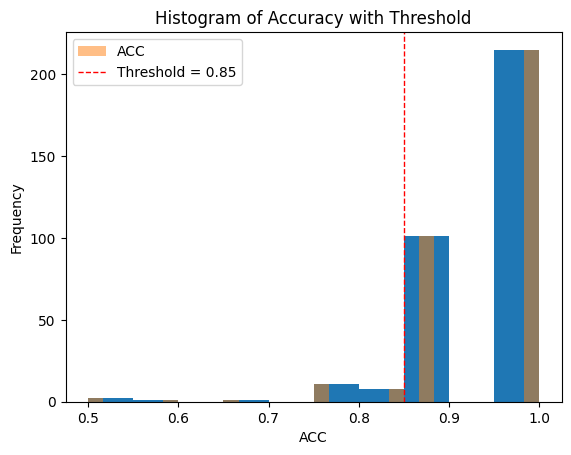

[1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]


In [12]:
filtered_df = language_df[language_df['ConditionName'] == 'STORY']
run_mean = filtered_df.groupby('Subject')[['ACC', 'AVG_DIFFICULTY_LEVEL', 'MEDIAN_RT']].mean().reset_index()

accuracy_m = run_mean[['Subject', 'ACC']]

accuracy_m.head()

#plt.hist(run_mean['ACC'])
plt.hist(run_mean['ACC'])

# Define the threshold
threshold = 0.85

# Function to assign the labels, if value in the column is above the threshold Ture, as tyoe converts boolean into binary numbers (0, 1)
accuracy_m['Label'] = (accuracy_m['ACC'] > threshold).astype(int)
print(accuracy_m)

# Histogram of average difficulty
plt.hist(accuracy_m['ACC'], bins=30, alpha=0.5, label='ACC')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label=f'Threshold = {threshold:.2f}')
plt.xlabel('ACC')
plt.ylabel('Frequency')
plt.title('Histogram of Accuracy with Threshold')
plt.legend()
plt.show()

# Vector de etiquetas
labels_vector_acc = accuracy_m['Label'].values
print(labels_vector_acc)

# PCA

In [13]:
# Aplanar la matriz de conectividad funcional para cada sujeto
lower_triangle_indices = np.tril_indices(N_PARCELS, k=-1)
flat_fc = [fc[lower_triangle_indices] for fc in f_connectivity_matrix]

# Convertir a un array de numpy con la forma correcta
flat_fc = np.vstack(flat_fc)

scaler = StandardScaler()
standardized_data = scaler.fit_transform(flat_fc)

print(standardized_data.shape)
# Perform PCA
pca = PCA(n_components= 50)
principal_components = pca.fit_transform(standardized_data)

print(principal_components.shape)

(339, 64620)
(339, 50)


In [14]:
explained_variance = pca.explained_variance_ratio_
weights = pca.components_
print(weights.shape)
weights_transposed = weights.T

# Create a DataFrame
weights_df = pd.DataFrame(weights_transposed, columns=[f"PC{i+1}" for i in range(weights.shape[0])], index=range(1, weights.shape[1] + 1))

print(weights_df)
print(max(weights_df))

(50, 64620)
            PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
1      0.004359 -0.001839 -0.002255  0.000474 -0.002874  0.000984  0.004164   
2      0.003839 -0.005077  0.002189  0.001472  0.004793 -0.000161  0.000977   
3      0.004081 -0.005387  0.001898  0.002631 -0.000012  0.000012  0.006678   
4      0.003739 -0.002738 -0.001349  0.000966 -0.002312  0.000969  0.003435   
5      0.004694 -0.004173 -0.002300  0.001982 -0.004329 -0.000263  0.002217   
...         ...       ...       ...       ...       ...       ...       ...   
64616  0.003437  0.003174 -0.000348  0.003390  0.003582 -0.002566 -0.010307   
64617  0.002814  0.006222 -0.002830  0.004603  0.005249  0.002224 -0.007066   
64618  0.002165  0.001059 -0.001355  0.004026  0.000252 -0.006382 -0.003401   
64619  0.003376  0.006515 -0.001348  0.002579  0.000952 -0.001513 -0.005667   
64620  0.004070  0.007839  0.003616 -0.000294 -0.000980 -0.000537 -0.001889   

            PC8       PC9      PC10  ..

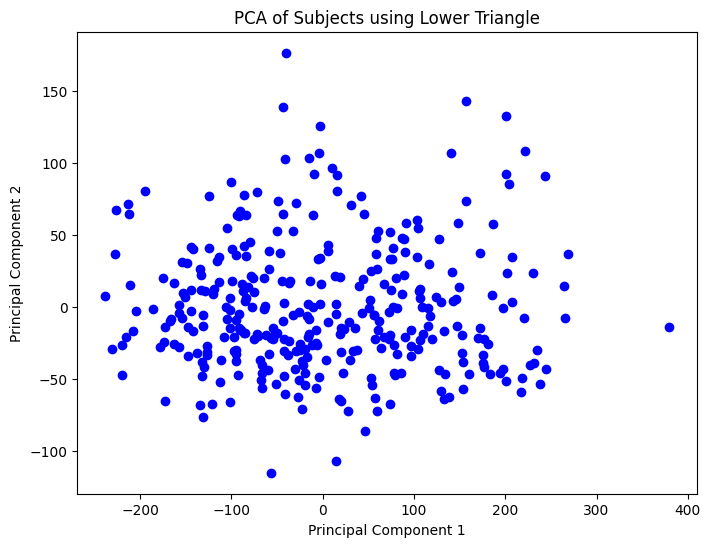

[[ 4.35892728e-03  3.83941358e-03  4.08115460e-03 ...  2.16502360e-03
   3.37552998e-03  4.06979356e-03]
 [-1.83934088e-03 -5.07676463e-03 -5.38718270e-03 ...  1.05934447e-03
   6.51467491e-03  7.83850750e-03]
 [-2.25482413e-03  2.18937318e-03  1.89819244e-03 ... -1.35498710e-03
  -1.34753052e-03  3.61633289e-03]
 ...
 [-2.91471842e-03  6.67742687e-04 -3.11137493e-03 ...  2.21279384e-03
   6.78373236e-03 -6.32902376e-04]
 [ 3.89191977e-03  2.46140820e-03  2.83753836e-03 ... -2.70099934e-03
  -6.24110312e-04 -2.17617383e-03]
 [ 2.78272866e-03  2.49437939e-03 -4.59206995e-03 ...  1.62285148e-05
   1.22114595e-03 -1.24150989e-03]]


In [15]:
# Step 4: Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c='blue')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Subjects using Lower Triangle')
plt.show()

# Explained variance
explained_variance = pca.explained_variance_ratio_
weights = pca.components_
print(weights)



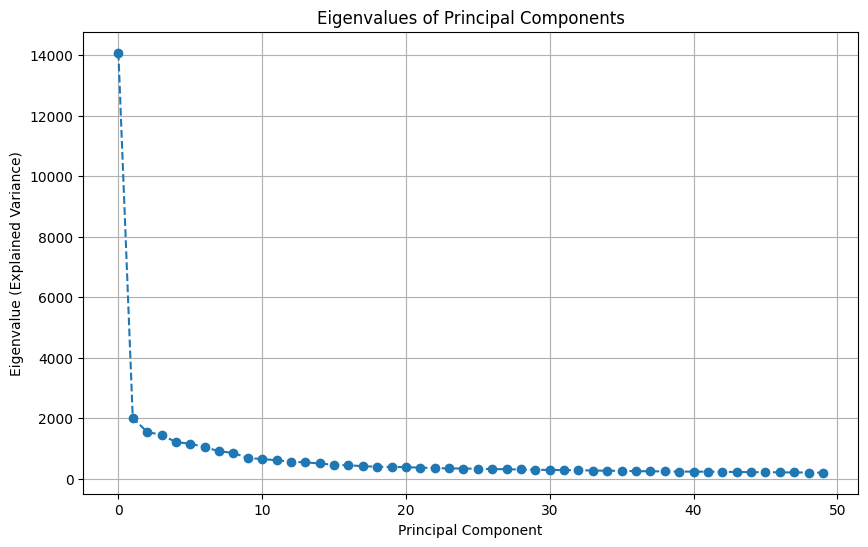

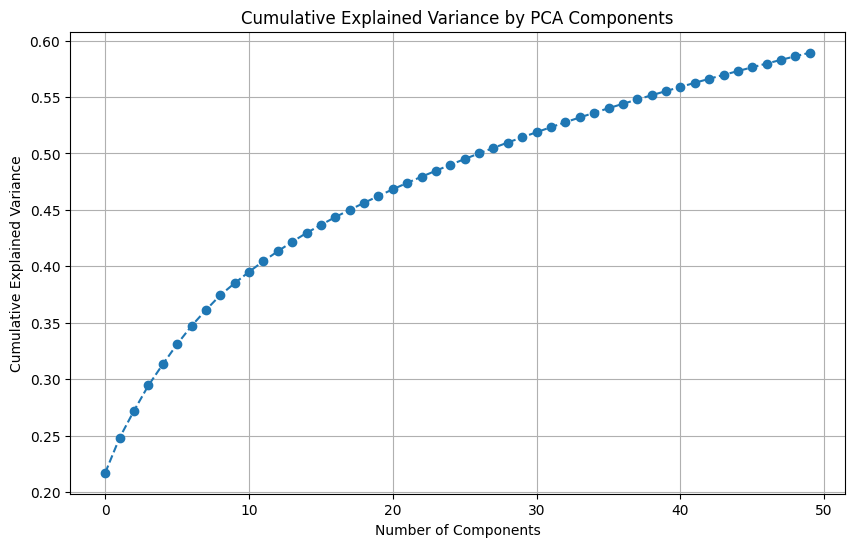

In [16]:
# # # Explained variance
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_

# # # Plot eigenvalues (explained variance)
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue (Explained Variance)')
plt.title('Eigenvalues of Principal Components')
plt.grid(True)
plt.show()

# # # Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

we can try to do a linear regression to predict the avg_difficult instead of a clasiffier and we won't need the labels

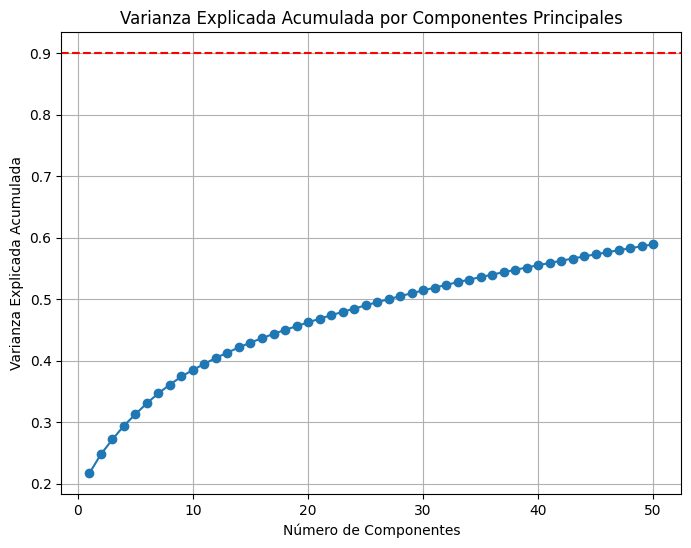

In [17]:
# Obtener la varianza explicada acumulada
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Graficar la varianza explicada acumulada
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por Componentes Principales')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--')  # Línea para 90% de varianza explicada
plt.show()


# The model starts here

In [18]:
avg_dif_df

Subject  AVG_DIFFICULTY_LEVEL  Label
0          0              8.892857      0
1          1             10.089286      0
2          2             10.053571      0
3          3              8.767857      0
4          4              9.357143      0
..       ...                   ...    ...
334      334             12.446429      1
335      335              8.750000      0
336      336              9.464286      0
337      337             11.178571      1
338      338              9.375000      0

[339 rows x 3 columns]

In [19]:
principal_components

array([[ 2.64627240e+02,  1.44694914e+01,  1.87420760e+01, ...,
        -3.22924192e+00,  1.50942384e+01,  1.29888599e+01],
       [ 8.67112886e+01,  9.06202784e+00, -2.57232219e+00, ...,
        -1.51435683e+01,  3.75369527e-02, -3.75502014e+00],
       [-1.48460283e+01, -1.89790730e+01,  5.17389052e+01, ...,
         3.77226236e+00,  7.42325638e+00, -3.26192546e+00],
       ...,
       [ 1.52455994e+02, -3.19731128e+01, -1.36314054e+00, ...,
        -3.62342608e+00,  1.61367062e+01,  2.64599802e+00],
       [-9.18736029e+01,  6.32506141e+01, -7.06544808e+00, ...,
        -1.30506146e+01,  1.27312025e+01, -2.92534403e+00],
       [-2.66237159e+01, -6.26889115e+01,  2.14395654e+01, ...,
         8.88640925e-01,  6.42750740e+00,  9.88011718e+00]])

# Classifier on Logistic regression PCA

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Assuming principal_components is your feature data and y is your target variable
X = principal_components
y = labels_vector  # Replace with your actual target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

Create the classifier and grid search for optimum parameters

In [21]:
# Initialize the classifier
classifier = LogisticRegression(random_state=42, solver = "liblinear")

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}

# Create the grid search object
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.01, 'penalty': 'l1'}
0.5869360269360269


Cross-validation and model prediction

In [22]:
classifier = LogisticRegression(C = 0.01, penalty= "l1", random_state=42, solver = "liblinear")

# Perform cross-validation
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5)

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV accuracy score: {cv_scores.mean()}')
print(f'CV score SD: {cv_scores.std()}')

classifier.fit(X_train, y_train)
# Make predictions
y_pred = classifier.predict(X_test)

y_pred_prob_pca_lr = classifier.predict_proba(X_test)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
#print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Cross-validation scores: [0.52727273 0.53703704 0.51851852 0.64814815 0.7037037 ]
Mean CV accuracy score: 0.5869360269360269
CV score SD: 0.07498291551909687
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.67      0.65        30
           1       0.72      0.68      0.70        38

    accuracy                           0.68        68
   macro avg       0.67      0.68      0.67        68
weighted avg       0.68      0.68      0.68        68



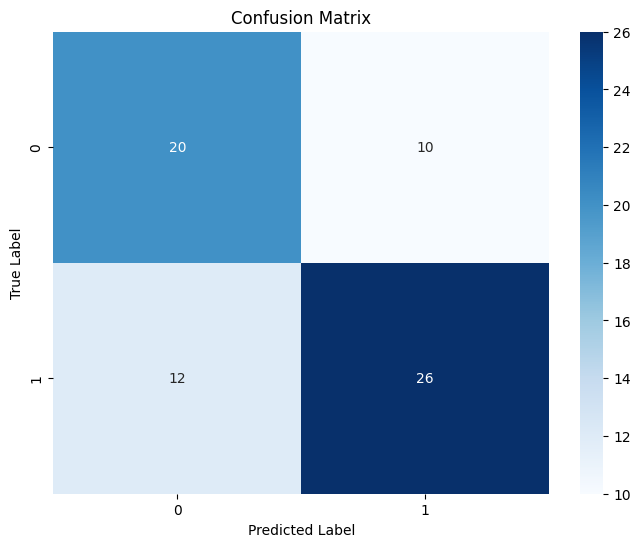

In [23]:
# Confussion matrix
matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance

Feature Importance:
Feature 22: 0.013852195919429563
Feature 16: 0.012523758376719811
Feature 17: 0.008873445907465393
Feature 23: 0.007596936576149614
Feature 26: 0.006721028805096591
Feature 38: 0.006108837933164041
Feature 5: 0.006036630904447228
Feature 14: 0.005454968525743993
Feature 4: 0.005236702245041864
Feature 2: 0.004496196346136943
Feature 9: 0.0036911230320459372
Feature 19: 0.0034244445982185563
Feature 25: 0.002682291521712913
Feature 46: 0.0025485849101010787
Feature 41: 0.002021037197279816
Feature 20: 0.0018919404019183874
Feature 13: 0.0018790143188013256
Feature 36: 0.001741796179450695
Feature 3: 0.0015903760848736835
Feature 0: 0.0011177333611359338
Feature 11: 8.66378308608075e-05
Feature 1: 0.0
Feature 6: 0.0
Feature 7: 0.0
Feature 8: 0.0
Feature 10: 0.0
Feature 12: 0.0
Feature 15: 0.0
Feature 18: 0.0
Feature 21: 0.0
Feature 24: 0.0
Feature 27: 0.0
Feature 28: 0.0
Feature 29: 0.0
Feature 30: 0.0
Feature 31: 0.0
Feature 32: 0.0
Feature 33: 0.0
Feature 34: 0.0
Fe

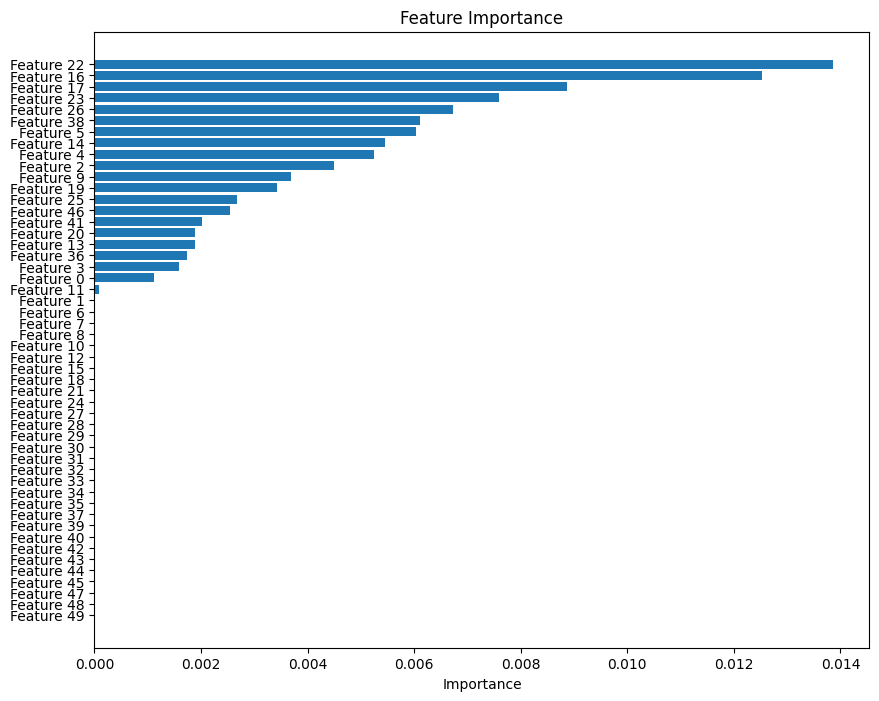

In [24]:
# Feature importance for logistic regression
if hasattr(classifier, 'coef_'):
    importance = np.abs(classifier.coef_[0])
    feature_names = [f'Feature {i}' for i in range(X.shape[1])]
    feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

    print('Feature Importance:')
    for feature, importance in feature_importance:
        print(f'{feature}: {importance}')

    # Plot feature importance
    feature_names, importances = zip(*feature_importance)
    plt.figure(figsize=(10, 8))
    plt.barh(feature_names, importances, align='center')
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Invert y axis to have the most important feature at the top
    plt.show()
else:
    print('The classifier does not have a `coef_` attribute.')

# XGboost


create model and parameter grid search

In [25]:
from xgboost import XGBClassifier

# Initialize the classifier
classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')


C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:15:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:15:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarnin

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
Best Score: 0.5792592592592593


Cross-validation and make predictions

C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [14:12:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [14:12:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarnin

Cross-validation scores: [0.6        0.59259259 0.51851852 0.53703704 0.64814815]
Mean CV accuracy score: 0.5792592592592593
CV score SD: 0.046531255628264906
Accuracy: 0.6764705882352942


C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [14:12:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


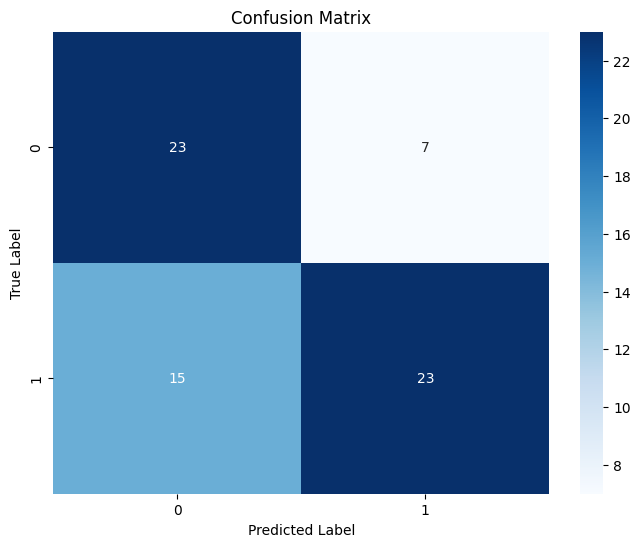

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.77      0.68        30
           1       0.77      0.61      0.68        38

    accuracy                           0.68        68
   macro avg       0.69      0.69      0.68        68
weighted avg       0.70      0.68      0.68        68



In [53]:
from sklearn.model_selection import GridSearchCV

classifier = XGBClassifier(n_estimators = 100, max_depth = 3, learning_rate = 0.1, subsample = 0.8, colsample_bytree = 0.8, use_label_encoder=False, eval_metric='logloss', random_state=42, gamma = 0.1, reg_alpha = 0.1, reg_lambda = 1)

cv_scores = cross_val_score(classifier, X_train, y_train, cv=5)

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV accuracy score: {cv_scores.mean()}')
print(f'CV score SD: {cv_scores.std()}')

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)
y_pred_prob_pca_xg = classifier.predict_proba(X_test)[:, 1]
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Compute the confusion matrix
matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)


# Random forrest on PCA

In [27]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create the random forest model
rf = RandomForestClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
0.5680134680134681


Cross-validation scores: [0.45454545 0.57407407 0.40740741 0.53703704 0.51851852]
Mean CV accuracy score: 0.4983164983164984
CV score SD: 0.05971093552514547
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.77      0.62        30
           1       0.71      0.45      0.55        38

    accuracy                           0.59        68
   macro avg       0.62      0.61      0.59        68
weighted avg       0.63      0.59      0.58        68



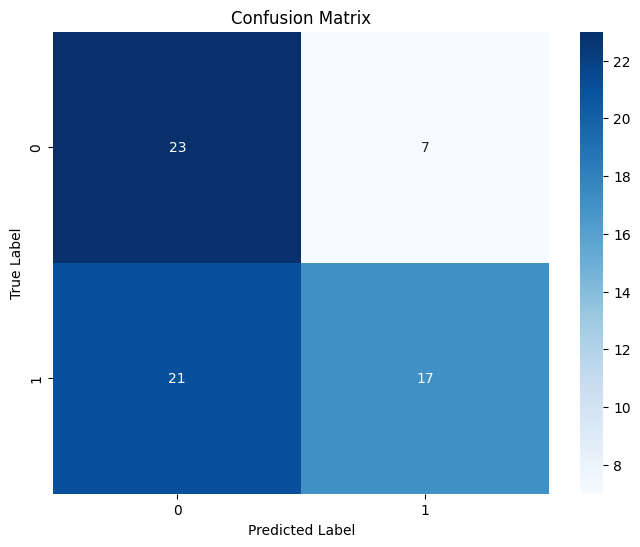

In [57]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(max_depth= 5, max_features= "log2", min_samples_leaf= 4, min_samples_split= 10, n_estimators= 100, random_state=42)

cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV accuracy score: {cv_scores.mean()}')
print(f'CV score SD: {cv_scores.std()}')

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)
y_pred_prob_pca_rf = rf_classifier.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# PCA SVM

Grid search 

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10], 
              'kernel': ['linear', 'rbf'], 
              'gamma': [0.1, 0.01]}

# Create the SVM model
svm = SVC()

# Create the grid search object
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.5424242424242425


Cross validation and model prediction

Cross-validation scores: [0.54545455 0.55555556 0.53703704 0.53703704 0.53703704]
Mean CV accuracy score: 0.5424242424242425
CV score SD: 0.007330485204403094
Accuracy: 0.4411764705882353
Classification Report:
              precision    recall  f1-score   support

           0       0.44      1.00      0.61        30
           1       0.00      0.00      0.00        38

    accuracy                           0.44        68
   macro avg       0.22      0.50      0.31        68
weighted avg       0.19      0.44      0.27        68



C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

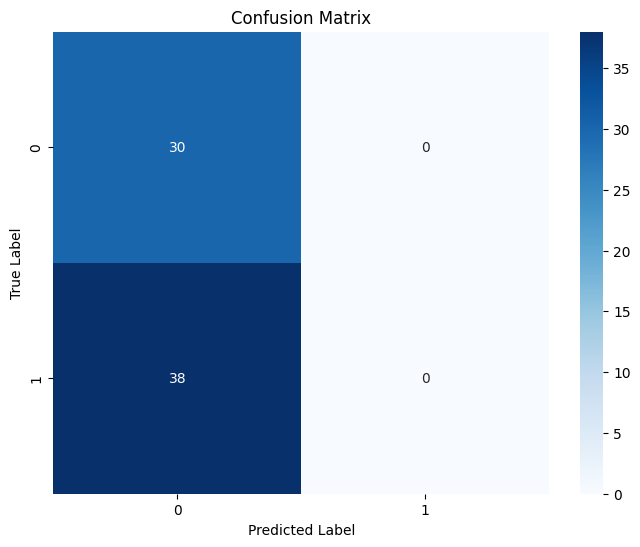

In [60]:
classifier = SVC(C = 0.1, gamma = 0.1, kernel = "rbf", random_state=42, probability=True)

cv_scores = cross_val_score(classifier, X_train, y_train, cv=5)

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV accuracy score: {cv_scores.mean()}')
print(f'CV score SD: {cv_scores.std()}')

# train the classifier
classifier.fit(X_train, y_train)

# Make the predictions
y_pred = classifier.predict(X_test)
y_pred_prob_pca_svm = classifier.predict_proba(X_test)[:, 1]


# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

# confussion matrix
matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Cross-validation scores: [0.54545455 0.55555556 0.53703704 0.53703704 0.53703704]
Mean CV accuracy score: 0.5424242424242425
CV score SD: 0.007330485204403094
Accuracy: 0.4411764705882353
Classification Report:
              precision    recall  f1-score   support

           0       0.44      1.00      0.61        30
           1       0.00      0.00      0.00        38

    accuracy                           0.44        68
   macro avg       0.22      0.50      0.31        68
weighted avg       0.19      0.44      0.27        68



C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

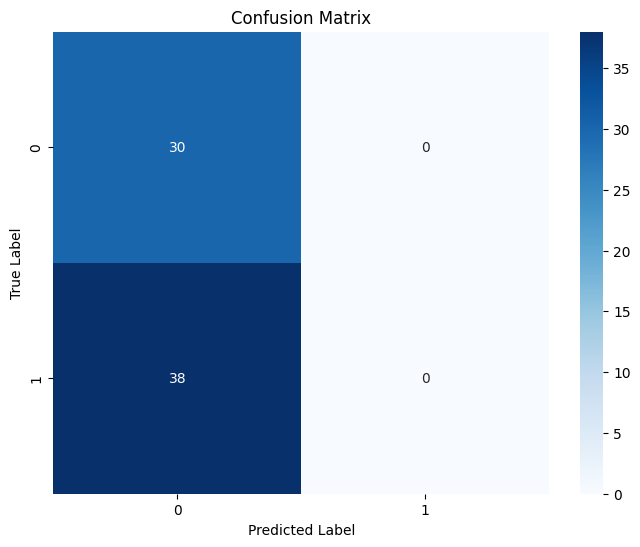

In [31]:
#SVM classifier
classifier = SVC(C = 0.1, gamma= 0.1, kernel='rbf', random_state=42, probability=True)

cv_scores = cross_val_score(classifier, X_train, y_train, cv=5)

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV accuracy score: {cv_scores.mean()}')
print(f'CV score SD: {cv_scores.std()}')

# train the classifier
classifier.fit(X_train, y_train)

# Make the predictions
y_pred = classifier.predict(X_test)
y_pred_prob_pca_svm = classifier.predict_proba(X_test)[:, 1]


# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

# confussion matrix
matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Linear Regression on PCA

In [32]:
from sklearn.linear_model import LinearRegression

y_avg_data = avg_dif_df['AVG_DIFFICULTY_LEVEL'].values
y_avg = normalize(y_avg_data.reshape(-1, 1), norm='l2', axis=0)

scaler = StandardScaler()
standardized_y_tsne = scaler.fit_transform(y_avg)


X_train_pca_lr, X_test_pca_lr, y_train_pca_lr, y_test_pca_lr = train_test_split(X, standardized_y_tsne, test_size=0.2, train_size=0.8, random_state=42)
model = LinearRegression()
model.fit(X_train_pca_lr, y_train_pca_lr)

# Make predictions on the test data
y_pred_pca_lr = model.predict(X_test_pca_lr)

# Evaluate the model
mse_pca_lr = mean_squared_error(y_test_pca_lr, y_pred_pca_lr)
print("Mean Squared Error:", mse_pca_lr)

Mean Squared Error: 0.9143062999640101


# TSNE

TSNE plots

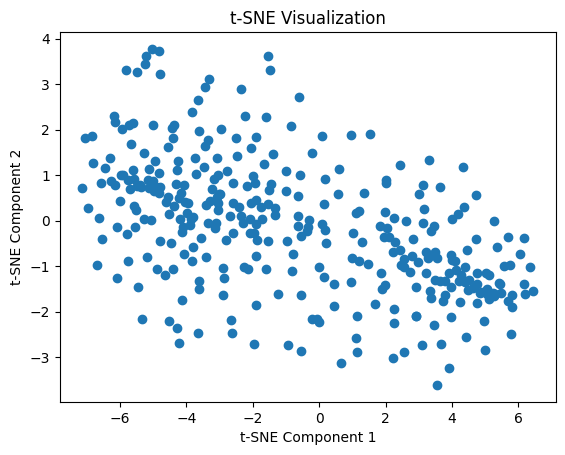

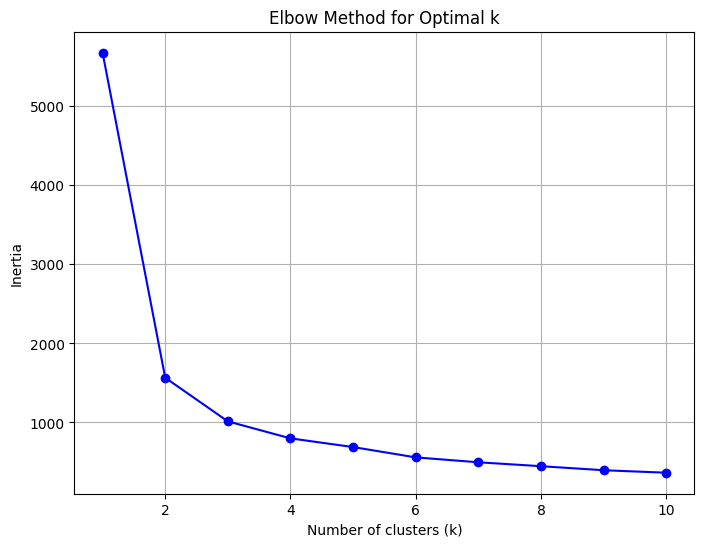

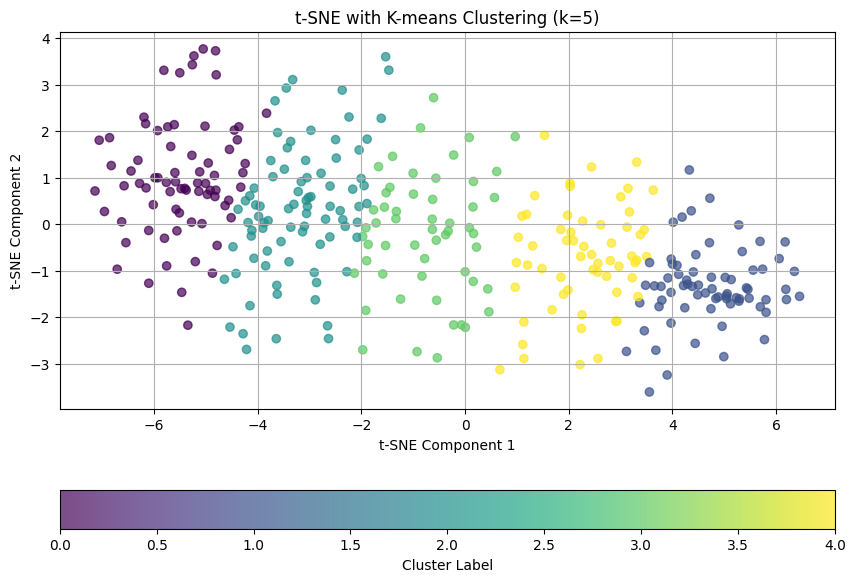

              ACC  AVG_DIFFICULTY_LEVEL    MEDIAN_RT
Cluster                                             
0        0.939498             10.182078  3291.160959
1        0.954762             10.380612  3365.275000
2        0.947289             10.429360  3303.159639
3        0.941358             10.458774  3304.550926
4        0.943503             10.280165  3274.474576
Cluster 0 (Cyan), Cluster 1 (Yellow), Cluster 2 (Purple)


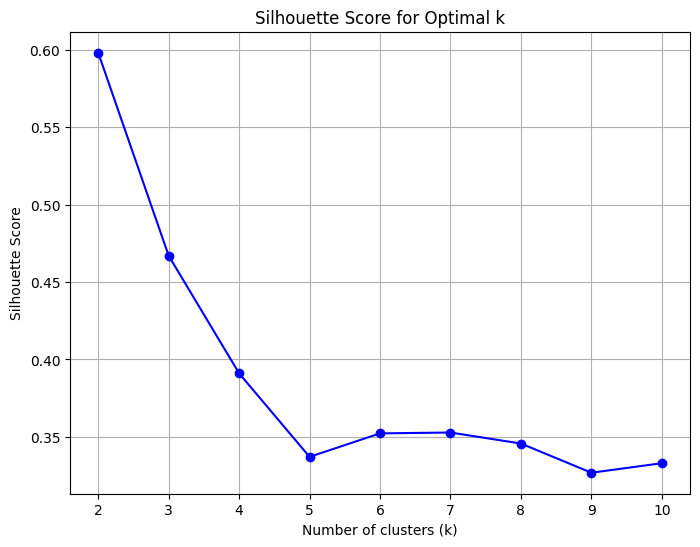

In [33]:
from sklearn.cluster import KMeans

# Using t-SNE results with perplexity=30 for clustering
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
tsne_result = tsne.fit_transform(standardized_data)
#labels = [roi_to_category[i] for i in range(len(flat_fc))]
#print(labels)


# Visualize components using labels
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.show()
# Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tsne_result)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(tsne_result)

# Add cluster labels to the run_mean DataFrame
run_mean['Cluster'] = labels

# Visualize the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('t-SNE with K-means Clustering (k=5)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, orientation='horizontal', label='Cluster Label')
plt.grid(True)
plt.show()

# Analyze the clusters
cluster_summary = run_mean.groupby('Cluster')[['ACC', 'AVG_DIFFICULTY_LEVEL', 'MEDIAN_RT']].mean()
print(cluster_summary)

print('Cluster 0 (Cyan), Cluster 1 (Yellow), Cluster 2 (Purple)')

from sklearn.metrics import silhouette_score

# Silhouette Score Method
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(tsne_result)
    silhouette_scores.append(silhouette_score(tsne_result, labels))

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)
plt.show()



Split the data

In [34]:
X_tnse = tsne_result
y = labels_vector 
X_train_tnse, X_test_tnse, y_train_tnse, y_test_tnse = train_test_split(X_tnse, y, test_size=0.2, train_size=0.8, random_state=42)

# LogR classifier on tsne

In [35]:
# Initialize the classifier
classifier = LogisticRegression(random_state=42, solver = "liblinear")

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}

# Create the grid search object
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_tnse, y_train_tnse)

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.001, 'penalty': 'l1'}
0.5424242424242425


Cross-validation scores: [0.54545455 0.55555556 0.53703704 0.53703704 0.53703704]
Mean CV accuracy score: 0.5424242424242425
CV score SD: 0.007330485204403094
Classification Report:
              precision    recall  f1-score   support

           0       0.44      1.00      0.61        30
           1       0.00      0.00      0.00        38

    accuracy                           0.44        68
   macro avg       0.22      0.50      0.31        68
weighted avg       0.19      0.44      0.27        68



C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

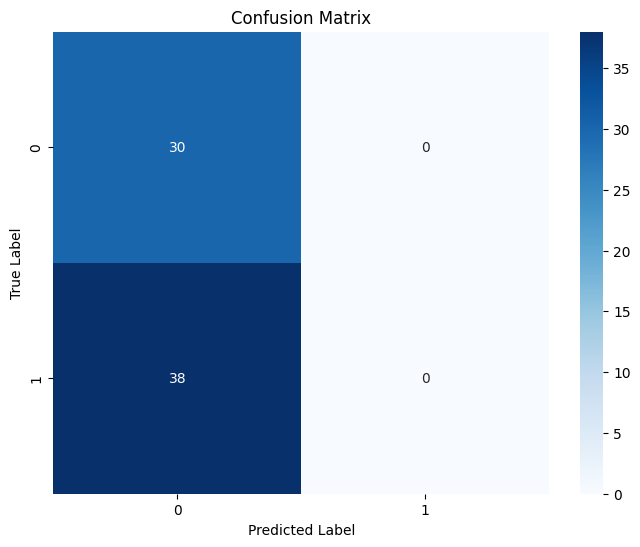

In [36]:
# Initialize the classifier
classifier = LogisticRegression(C = 0.001, penalty= "l1", random_state=42, solver = "liblinear")

cv_scores = cross_val_score(classifier, X_train_tnse, y_train_tnse, cv=5)

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV accuracy score: {cv_scores.mean()}')
print(f'CV score SD: {cv_scores.std()}')

# Train the classifier
classifier.fit(X_train_tnse, y_train_tnse)

# Make predictions
y_pred_tnse_lr = classifier.predict(X_test_tnse)
y_pred_prob_tsne_lr = classifier.predict_proba(X_test_tnse)[:, 1]

report_tnse = classification_report(y_test_tnse, y_pred_tnse_lr)
print('Classification Report:')
print(report_tnse)

matrix_tnse = confusion_matrix(y_test_tnse, y_pred_tnse_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_tnse, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



# Linear Regression on Tsne (no classifier)

In [37]:
from sklearn.linear_model import LinearRegression
import statsmodels 

y_avg_data = avg_dif_df['AVG_DIFFICULTY_LEVEL'].values
y_avg = normalize(y_avg_data.reshape(-1, 1), norm='l2', axis=0)

scaler = StandardScaler()
standardized_y_tsne = scaler.fit_transform(y_avg)

X_train_tsne_lr, X_test_tsne_lr, y_train_tsne_lr, y_test_tsne_lr = train_test_split(X_tnse, standardized_y_tsne, test_size=0.2, train_size=0.8, random_state=42)
model = LinearRegression()
model.fit(X_train_tsne_lr, y_train_tsne_lr)

# Make predictions on the test data
y_pred_tsne_lr = model.predict(X_test_tsne_lr)

# Evaluate the model
mse_tsne_lr = mean_squared_error(y_test_tnse, y_pred_tsne_lr)
print("Mean Squared Error:", mse_tsne_lr)
# regression coefficients
print('Coefficients: ', model.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(model.score(X_test_tsne_lr, y_test_tsne_lr)))


Mean Squared Error: 0.6481424377607833
Coefficients:  [[-0.00720396 -0.0557317 ]]
Variance score: -0.12869271789450254


# Random forrest on tsne

In [38]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create the random forest model
rf = RandomForestClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_tnse, y_train_tnse)

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
0.6049831649831651


Cross-validation scores: [0.6        0.61111111 0.48148148 0.72222222 0.53703704]
Mean CV accuracy score: 0.5903703703703704
CV score SD: 0.08075772842018575
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.77      0.54        30
           1       0.46      0.16      0.24        38

    accuracy                           0.43        68
   macro avg       0.44      0.46      0.39        68
weighted avg       0.44      0.43      0.37        68



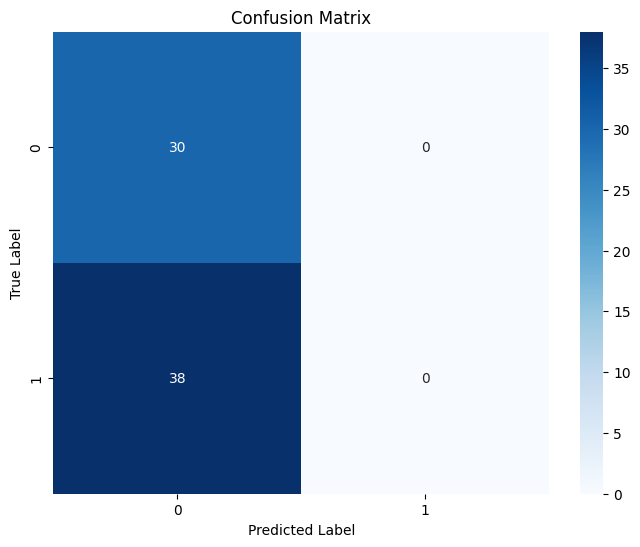

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Assuming you have X_train, y_train, X_test, and y_test defined

# Create a Random Forest classifier
classifier_tsne = RandomForestClassifier(max_depth= 5, max_features= "sqrt", min_samples_leaf=4, min_samples_split= 5, n_estimators=300, random_state=42)

cv_scores = cross_val_score(classifier_tsne, X_train_tnse, y_train_tnse, cv=5)

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV accuracy score: {cv_scores.mean()}')
print(f'CV score SD: {cv_scores.std()}')
# Train the classifier on the training data
classifier_tsne.fit(X_train_tnse, y_train_tnse)

# Make predictions on the test data
y_pred_tnse_rf = classifier_tsne.predict(X_test_tnse)
y_pred_prob_tsne_rf = classifier.predict_proba(X_test_tnse)[:, 1]

report_tnse = classification_report(y_test_tnse, y_pred_tnse_rf)
print('Classification Report:')
print(report_tnse)

matrix_tnse = confusion_matrix(y_test_tnse, y_pred_tnse_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_tnse, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# XGBoost on TSNE

Cross-validation scores: [0.6        0.61111111 0.48148148 0.72222222 0.53703704]
Mean CV accuracy score: 0.5903703703703704
CV score SD: 0.08075772842018575
Accuracy: 0.6029411764705882
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60        30
           1       0.68      0.55      0.61        38

    accuracy                           0.60        68
   macro avg       0.61      0.61      0.60        68
weighted avg       0.62      0.60      0.60        68



C:\Users\cwako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:43:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


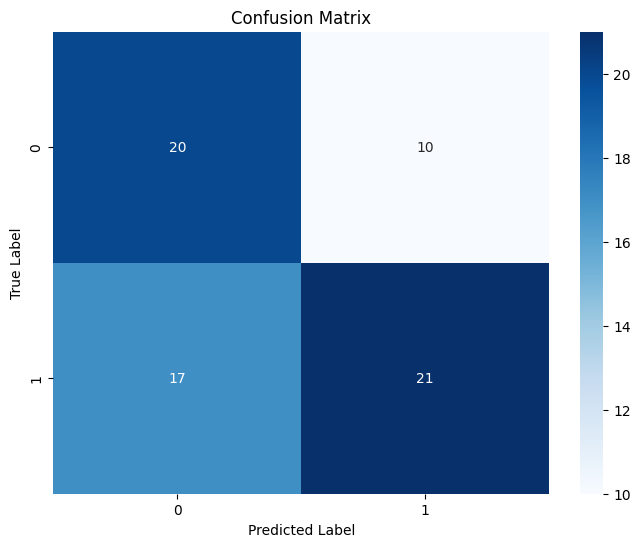

In [40]:
from xgboost import XGBClassifier

# Initialize the classifier
classifier = XGBClassifier(n_estimators = 200, max_depth = 5, learning_rate = 0.1, subsample = 0.8, colsample_bytree = 0.8, use_label_encoder=False, eval_metric='logloss', random_state=42, gamma = 0, reg_alpha = 0, reg_lambda = 1)

cv_scores = cross_val_score(classifier_tsne, X_train_tnse, y_train_tnse, cv=5)

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV accuracy score: {cv_scores.mean()}')
print(f'CV score SD: {cv_scores.std()}')

# Train the classifier
classifier.fit(X_train_tnse, y_train_tnse)

# Make predictions
y_pred_t_xg = classifier.predict(X_test_tnse)
y_pred_prob_tsne_xg = classifier.predict_proba(X_test_tnse)[:, 1]

# Evaluate the classifier
accuracy_tx = accuracy_score(y_test_tnse, y_pred_t_xg)
print(f'Accuracy: {accuracy_tx}')

report_tnse = classification_report(y_test_tnse, y_pred_t_xg)
print('Classification Report:')
print(report_tnse)
# Compute the confusion matrix
matrix = confusion_matrix(y_test_tnse, y_pred_t_xg)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# SVM on tsne

In [41]:
param_grid = {'C': [0.1, 1, 10], 
              'kernel': ['linear', 'rbf'], 
              'gamma': [0.1, 0.01]}

# Create the SVM model
svm = SVC()

# Create the grid search object
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_tnse, y_train_tnse)

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.5755555555555556


Cross-validation scores: [0.6        0.57407407 0.44444444 0.64814815 0.61111111]
Mean CV accuracy score: 0.5755555555555556
CV score SD: 0.06974773277827168
Accuracy: 0.3382352941176471
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.63      0.46        30
           1       0.27      0.11      0.15        38

    accuracy                           0.34        68
   macro avg       0.31      0.37      0.30        68
weighted avg       0.31      0.34      0.29        68



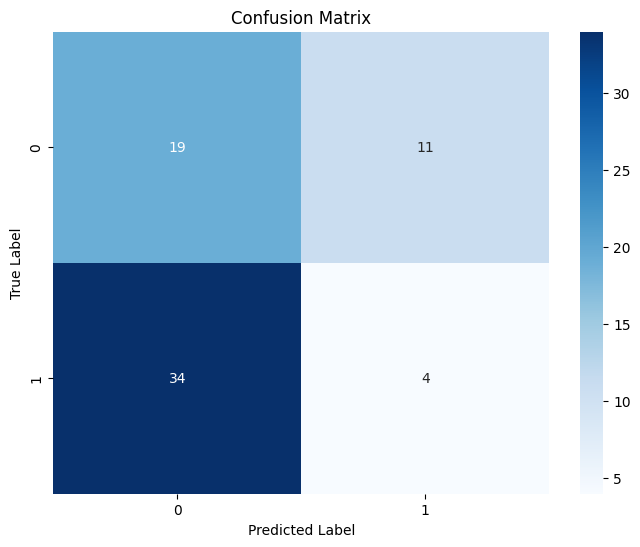

In [42]:
#SVM classifier
classifier = SVC(C = 1, gamma = 0.1, kernel='rbf', random_state=42, probability=True)


cv_scores = cross_val_score(classifier, X_train_tnse, y_train_tnse, cv=5)

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV accuracy score: {cv_scores.mean()}')
print(f'CV score SD: {cv_scores.std()}')

# train the classifier
classifier.fit(X_train_tnse, y_train_tnse)

# Make the predictions
y_pred_tsne_svm = classifier.predict(X_test_tnse)
y_pred_prob_tsne_svm = classifier.predict_proba(X_test_tnse)[:, 1]

accuracy_svm = accuracy_score(y_test_tnse, y_pred_tsne_svm)
print(f'Accuracy: {accuracy_svm}')
report = classification_report(y_test_tnse, y_pred_tsne_svm)
print('Classification Report:')
print(report)

# confussion matrix
matrix = confusion_matrix(y_test_tnse, y_pred_tsne_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

          Subject         ACC  AVG_DIFFICULTY_LEVEL    MEDIAN_RT     Cluster
count  339.000000  339.000000            339.000000   339.000000  339.000000
mean   169.000000    0.945551             10.344764  3308.631268    1.870206
std     98.005102    0.081906              1.462082   326.217813    1.382786
min      0.000000    0.500000              4.589286  2486.000000    0.000000
25%     84.500000    0.875000              9.383929  3067.250000    1.000000
50%    169.000000    1.000000             10.464286  3268.250000    2.000000
75%    253.500000    1.000000             11.500000  3490.500000    3.000000
max    338.000000    1.000000             12.571429  4476.500000    4.000000


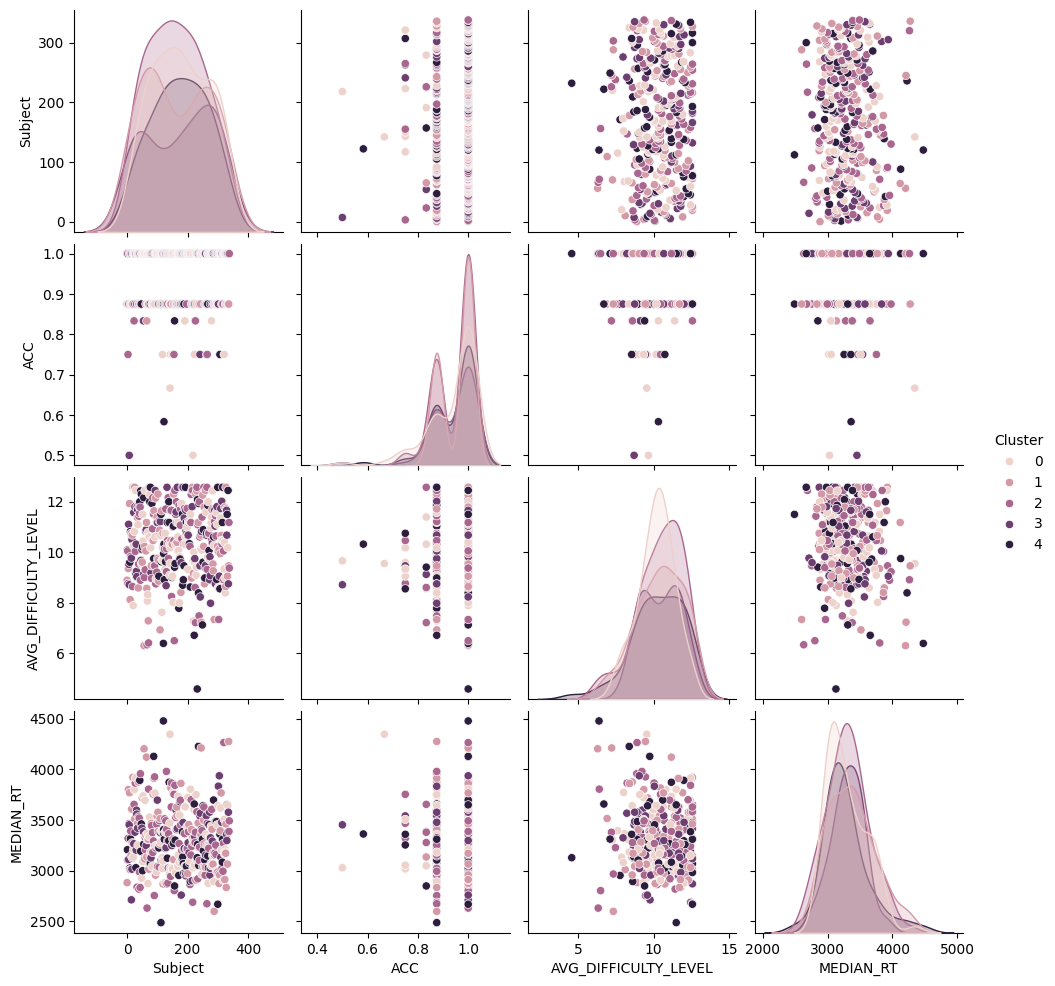

In [43]:
# Describe the data to check for anomalies
print(run_mean.describe())

# Plot the features to check for anomalies
import seaborn as sns

sns.pairplot(run_mean, hue='Cluster')
plt.show()


                       Subject       ACC  AVG_DIFFICULTY_LEVEL  MEDIAN_RT  \
Subject               1.000000  0.046747              0.009762  -0.070045   
ACC                   0.046747  1.000000              0.138452  -0.022500   
AVG_DIFFICULTY_LEVEL  0.009762  0.138452              1.000000  -0.108056   
MEDIAN_RT            -0.070045 -0.022500             -0.108056   1.000000   
Cluster               0.000131 -0.005985              0.028941  -0.037157   

                       Cluster  
Subject               0.000131  
ACC                  -0.005985  
AVG_DIFFICULTY_LEVEL  0.028941  
MEDIAN_RT            -0.037157  
Cluster               1.000000  


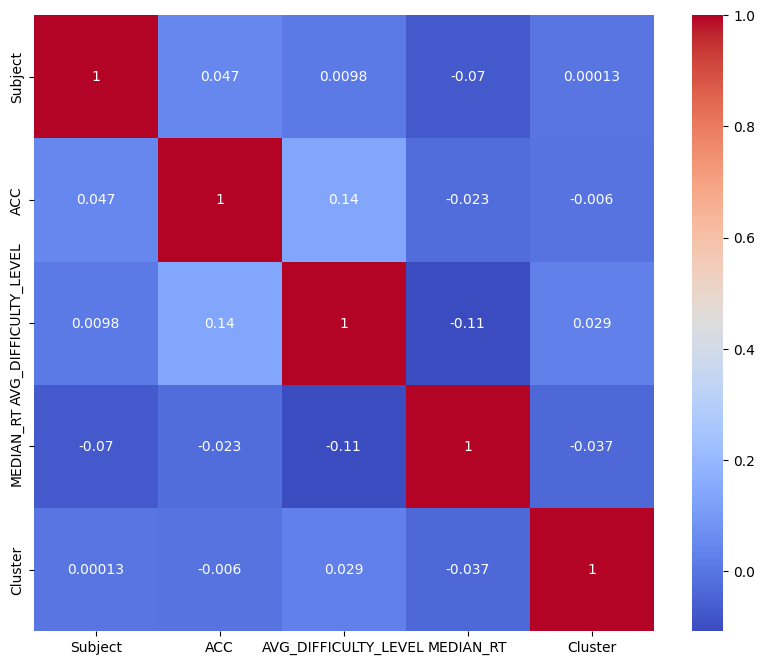

In [44]:
# Check for correlations
correlation_matrix = run_mean.corr()
print(correlation_matrix)

# Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Drop one of each pair of highly correlated features if necessary
# For example, if ACC and AVG_DIFFICULTY_LEVEL are highly correlated, you might drop one.


Cluster
2    83
0    73
1    70
4    59
3    54
Name: count, dtype: int64


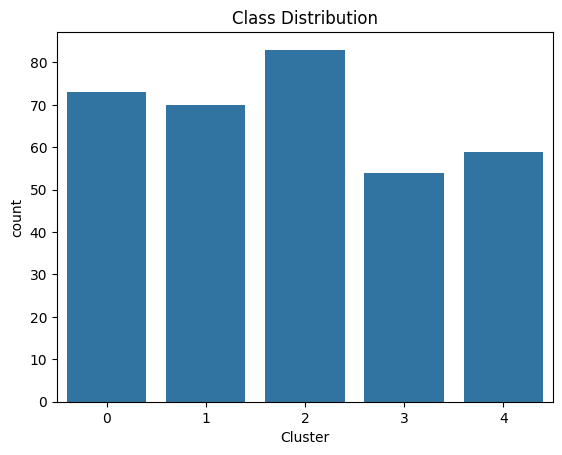

In [45]:
# Check for class imbalance
print(run_mean['Cluster'].value_counts())

# Visualize the class distribution
sns.countplot(x='Cluster', data=run_mean)
plt.title('Class Distribution')
plt.show()


# AUC-ROC plots

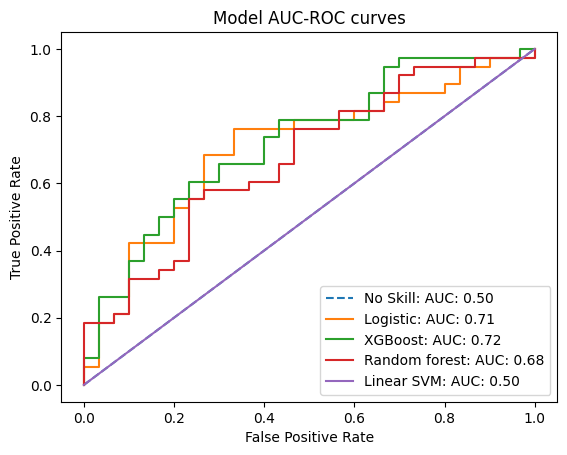

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ns_auc = roc_auc_score(y_test, ns_probs)

# PCA LogReg classifier AUC and ROC values
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_pred_prob_pca_lr)
lr_auc = roc_auc_score(y_test, y_pred_prob_pca_lr)


#PCA XGboost Classifier values
xg_fpr, xg_tpr, xg_thresholds = roc_curve(y_test, y_pred_prob_pca_xg)
xg_auc = roc_auc_score(y_test, y_pred_prob_pca_xg)

# PCA random forst classifier values
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_pred_prob_pca_rf)
rf_auc = roc_auc_score(y_test, y_pred_prob_pca_rf)

# PCA SVM values
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, y_pred_prob_pca_svm)
svm_auc = roc_auc_score(y_test, y_pred_prob_pca_svm)

#Plot all together
plt.plot(ns_fpr, ns_tpr, linestyle='--', label=f'No Skill: AUC: {ns_auc:.2f}')
plt.plot(lr_fpr, lr_tpr, marker='', label=f'Logistic: AUC: {lr_auc:.2f}')
plt.plot(xg_fpr, xg_tpr, marker='', label=f'XGBoost: AUC: {xg_auc:.2f}')
plt.plot(rf_fpr, rf_tpr, marker='', label=f'Random forest: AUC: {rf_auc:.2f}')
plt.plot(svm_fpr, svm_tpr, marker='', label=f'Linear SVM: AUC: {svm_auc:.2f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Model AUC-ROC curves")
# show the legend
plt.legend()
# show the plot
plt.show()

# calibration plots

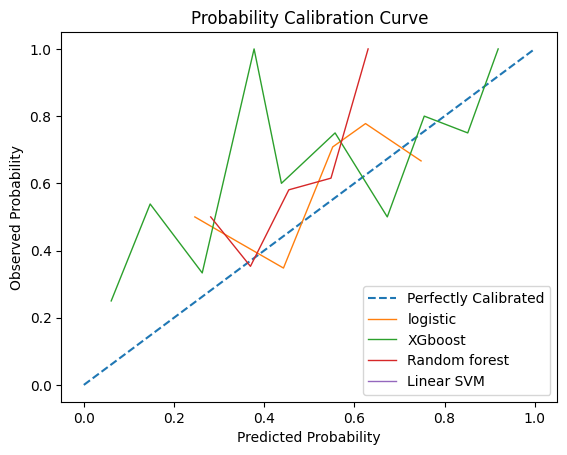

In [47]:
from sklearn.calibration import calibration_curve

# True and Predicted Probabilities SVM
true_pos_svm, pred_pos_svm = calibration_curve(y_test, y_pred_prob_pca_svm, n_bins=10)
true_pos_rf, pred_pos_rf = calibration_curve(y_test, y_pred_prob_pca_rf, n_bins=10)
true_pos_xg, pred_pos_xg = calibration_curve(y_test, y_pred_prob_pca_xg, n_bins=10)
true_pos_lr, pred_pos_lr = calibration_curve(y_test, y_pred_prob_pca_lr, n_bins=10)

#Plot the Perfectly Calibrated by Adding the 45-degree line to the plot
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')

#Plot the Probabilities Calibrated curve
plt.plot(pred_pos_lr, true_pos_lr, marker='', linewidth=1, label='logistic')
plt.plot(pred_pos_xg, true_pos_xg, marker='', linewidth=1, label='XGboost')
plt.plot(pred_pos_rf, true_pos_rf, marker='', linewidth=1, label='Random forest')
plt.plot(pred_pos_svm, true_pos_svm, marker='', linewidth=1, label='Linear SVM')

# Set the title and axis labels for the plot
plt.title('Probability Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
 
# Add a legend to the plot
plt.legend(loc='best')
 
# Show the plot
plt.show()

# TSNE Plots

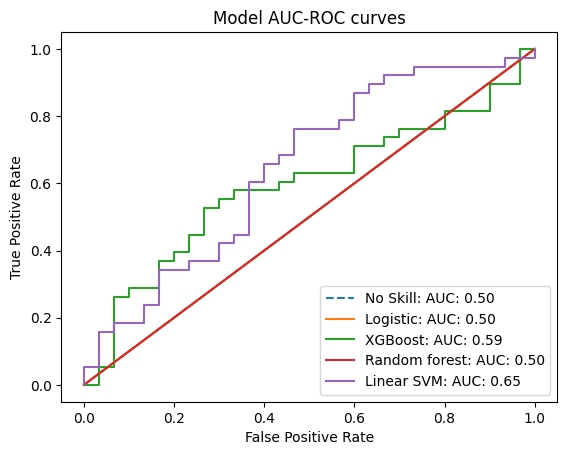

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test_tnse))]
ns_fpr, ns_tpr, _ = roc_curve(y_test_tnse, ns_probs)
ns_auc = roc_auc_score(y_test_tnse, ns_probs)

# TSNE LogReg classifier AUC and ROC values
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test_tnse, y_pred_prob_tsne_lr)
lr_auc = roc_auc_score(y_test_tnse, y_pred_prob_tsne_lr)


#PCA XGboost Classifier values
xg_fpr, xg_tpr, xg_thresholds = roc_curve(y_test_tnse, y_pred_prob_tsne_xg)
xg_auc = roc_auc_score(y_test_tnse, y_pred_prob_tsne_xg)

# PCA random forst classifier values
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test_tnse, y_pred_prob_tsne_rf)
rf_auc = roc_auc_score(y_test_tnse, y_pred_prob_tsne_rf)

# PCA SVM values
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test_tnse, y_pred_prob_tsne_svm)
svm_auc = roc_auc_score(y_test_tnse, y_pred_prob_tsne_svm)

#Plot all together
plt.plot(ns_fpr, ns_tpr, linestyle='--', label=f'No Skill: AUC: {ns_auc:.2f}')
plt.plot(lr_fpr, lr_tpr, marker='', label=f'Logistic: AUC: {lr_auc:.2f}')
plt.plot(xg_fpr, xg_tpr, marker='', label=f'XGBoost: AUC: {xg_auc:.2f}')
plt.plot(rf_fpr, rf_tpr, marker='', label=f'Random forest: AUC: {rf_auc:.2f}')
plt.plot(svm_fpr, svm_tpr, marker='', label=f'Linear SVM: AUC: {svm_auc:.2f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Model AUC-ROC curves")

# Add a legend to the plot
plt.legend(loc='best')
 
# Show the plot
plt.show()

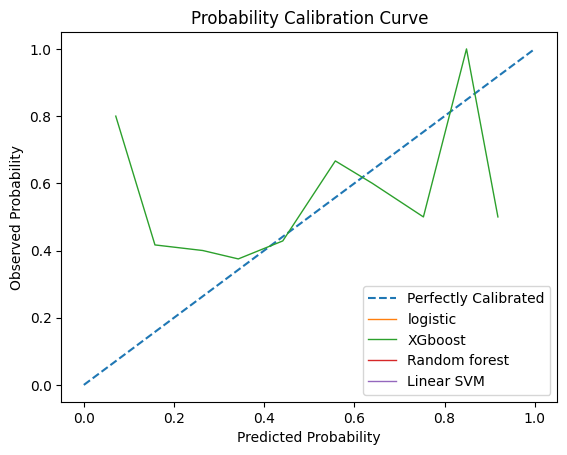

In [49]:
from sklearn.calibration import calibration_curve

# True and Predicted Probabilities SVM
true_pos_svm, pred_pos_svm = calibration_curve(y_test_tnse, y_pred_prob_tsne_svm, n_bins=10)
true_pos_rf, pred_pos_rf = calibration_curve(y_test_tnse, y_pred_prob_tsne_rf, n_bins=10)
true_pos_xg, pred_pos_xg = calibration_curve(y_test_tnse, y_pred_prob_tsne_xg, n_bins=10)
true_pos_lr, pred_pos_lr = calibration_curve(y_test_tnse, y_pred_prob_tsne_lr, n_bins=10)

#Plot the Perfectly Calibrated by Adding the 45-degree line to the plot
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')

#Plot the Probabilities Calibrated curve
plt.plot(pred_pos_lr, true_pos_lr, marker='', linewidth=1, label='logistic')
plt.plot(pred_pos_xg, true_pos_xg, marker='', linewidth=1, label='XGboost')
plt.plot(pred_pos_rf, true_pos_rf, marker='', linewidth=1, label='Random forest')
plt.plot(pred_pos_svm, true_pos_svm, marker='', linewidth=1, label='Linear SVM')

# Set the title and axis labels for the plot
plt.title('Probability Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
 
# Add a legend to the plot
plt.legend(loc='best')
 
# Show the plot
plt.show()

In [50]:
print(true_pos_xg, pred_pos_xg)

[0.8        0.41666667 0.4        0.375      0.42857143 0.66666667
 0.6        0.5        1.         0.5       ] [0.07084571 0.15775695 0.26384509 0.34255393 0.44124738 0.55774646
 0.63984828 0.75311444 0.84867743 0.9183445 ]
